In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [150]:
data = pd.read_csv('train.csv')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [151]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Types of variables  

Let's find out what types of variables there are in this dataset

In [152]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

There are categorical and numerical variables.

In [153]:
# let's inspect the variable values

for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

PassengerId [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 

Survived [0 1] 

Pclass [3 1 2] 

Name ['Braund, Mr. Owen Harris'
 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Heikkinen, Miss. Laina' 'Futrelle, Mrs. Jacques Heath (Lily May Peel)'
 'Allen, Mr. William Henry' 'Moran, Mr. James' 'McCarthy, Mr. Timothy J'
 'Palsson, Master. Gosta Leonard'
 'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)'
 'Nasser, Mrs. Nicholas (Adele Achem)' 'Sandstrom, Miss. Marguerite Rut'
 'Bonnell, Miss. Elizabeth' 'Saundercock, Mr. William Henry'
 'Andersson, Mr. Anders Johan' 'Vestrom, Miss. Hulda Amanda Adolfina'
 'Hewlett, Mrs. (Mary D Kingcome) ' 'Rice, Master. Eugene'
 'Williams, Mr. Charles Eugene'
 'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)'
 'Masselmani, Mrs. Fatima'] 

Sex ['male' 'female'] 

Age [22. 38. 26. 35. nan 54.  2. 27. 14.  4. 58. 20. 39. 55. 31. 34. 15. 28.
  8. 19.] 

SibSp [1 0 3 4 2 5 8] 

Parch [0 1 2 5 3 4 6] 

Ticket ['A/5 21171' 'PC 1

There continuous and discrete variables and also mixed variables.

In [163]:
# make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='Survived' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='Survived' and var not in discrete]

# mixed
mixed = ['Cabin','Ticket']

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var not in mixed]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))

There are 3 discrete variables
There are 3 continuous variables
There are 3 categorical variables
There are 2 mixed variables


In [164]:
discrete

['Pclass', 'SibSp', 'Parch']

In [165]:
continuous

['PassengerId', 'Age', 'Fare']

In [166]:
categorical

['Name', 'Sex', 'Embarked']

In [167]:
mixed

['Cabin', 'Ticket']

### Variable characteristics

In [161]:
# missing data

data.isnull().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

There is missing data in our variables.

In [168]:
# cardinality (number of different categories)

data[categorical+mixed].nunique()

Name        891
Sex           2
Embarked      3
Cabin       147
Ticket      681
dtype: int64

Some variables are highly cardinal.

<AxesSubplot:>

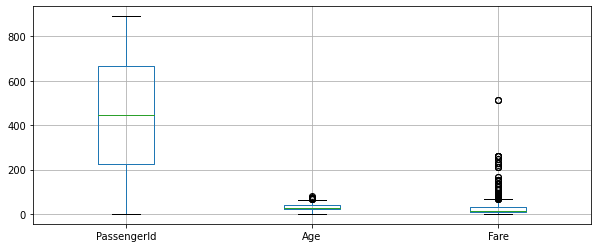

In [169]:
# outliers

data[continuous].boxplot(figsize=(10,4))

<AxesSubplot:>

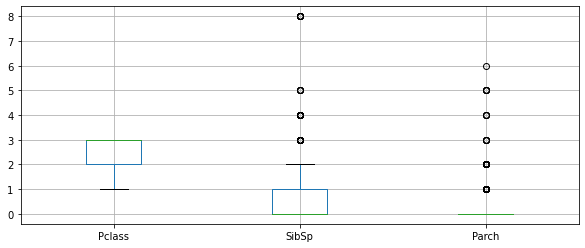

In [170]:
# outliers in discrete
data[discrete].boxplot(figsize=(10,4))

Some variables show outliers or unusual values.


In [172]:
# values bigger than 3 are rare for parch

data['Parch'].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [174]:
data['SibSp'].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [130]:
# feature magnitude

data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


Features are in different ranges or scales. But this is not relevant for gradient boosted trees.

### Engineering mixed type of variables  

Extract numerical and categorical parts of variables.



In [175]:
# Cabin
data['Cabin_num'] = data['Cabin'].str.extract('(\d+)') # captures numerical part
data['Cabin_num'] = data['Cabin_num'].astype('float')
data['Cabin_cat'] = data['Cabin'].str[0] # captures the first letter

# show dataframe
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_num,Cabin_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,NaN,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,85.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,NaN,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,123.0,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,NaN,NaN


Now that we extracted the numerical and categorical part, we can discard the mixed variable Cabin.

In [176]:
# drop original mixed

data.drop(['Cabin'], axis=1, inplace=True)

In [177]:
# cardinality high as number of records in dataset

data.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True)

In [179]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Survived', axis=1),  # predictors
    data['Survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((801, 9), (90, 9))

### Missing data imputation

In [180]:
# numerical

X_train.select_dtypes(exclude='O').isnull().mean()

Pclass       0.000000
Age          0.197253
SibSp        0.000000
Parch        0.000000
Fare         0.000000
Cabin_num    0.781523
dtype: float64

In [181]:
# categorical

X_train.select_dtypes(include='O').isnull().mean()

Sex          0.000000
Embarked     0.002497
Cabin_cat    0.776529
dtype: float64

Imputation methods I will perform:

    * Numerical: arbitrary value imputation
    * Categorical: add missing label imputation
    
Because I will build a Gradient Boosted tree, I am not particularly worried about disturbing linearity or distributions of variables.

### Categorical encoding and rare labels

In [183]:
# check cardinality again

X_train[['Cabin_cat', 'Sex', 'Embarked']].nunique()

Cabin_cat    8
Sex          2
Embarked     3
dtype: int64

In [184]:
# check variable frequency

var = 'Cabin_cat'
(X_train[var].value_counts() / len(X_train)).sort_values()

T    0.001248
G    0.004994
F    0.014981
A    0.018727
D    0.034956
E    0.037453
B    0.051186
C    0.059925
Name: Cabin_cat, dtype: float64

Categories T and G appear only in few observations, so I will replace them into rare.

### Discretisation or Variable transformation

Let's inspect the variable distributions.

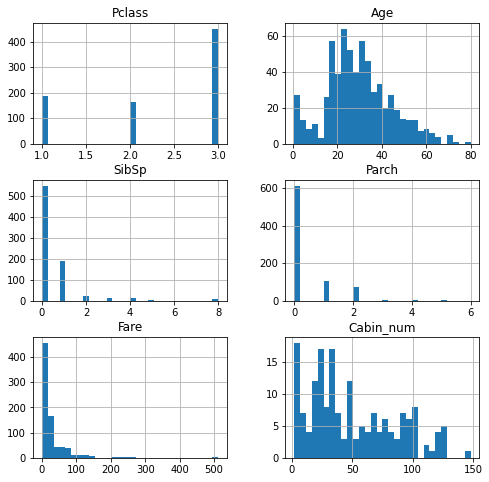

In [185]:
# numerical

X_train.select_dtypes(exclude='O').hist(bins=30, figsize=(8,8))
plt.show()

For decision trees, the variable distribution is not so important, so in principle, we don't need to change it. Also decision trees are robust to outliers.

In [186]:
titanic_pipe = Pipeline([

    # missing data imputation - section 4
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['Age', 'Fare', 'Cabin_num'])),
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['Embarked', 'Cabin_cat'])),

    # categorical encoding - section 6
    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                                    n_categories=6,
                                    variables=['Cabin_cat'])),
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                                  variables=['Cabin_cat', 'Sex', 'Embarked'])),

    # Gradient Boosted machine
    ('gbm', GradientBoostingClassifier(random_state=0))
])

In [187]:
# let's fit the pipeline and make predictions
titanic_pipe.fit(X_train, y_train)

X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [188]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.9466380372977057
Test set
GBM roc-auc: 0.9185520361990951


<AxesSubplot:>

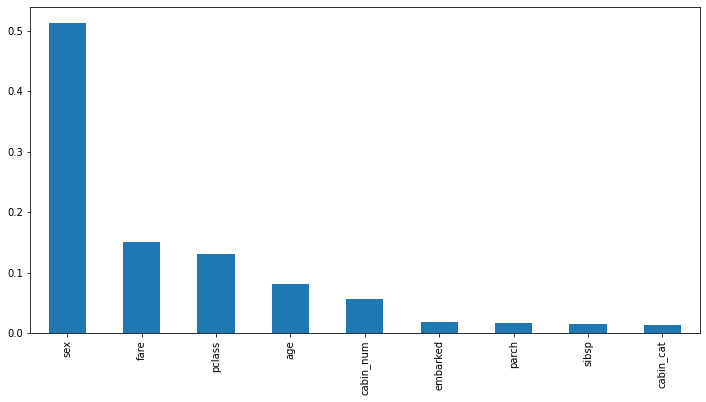

In [148]:
# let's explore the importance of the features

importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))

In [189]:
new_data = pd.read_csv('test.csv')

new_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [190]:
# Cabin
new_data['Cabin_num'] = new_data['Cabin'].str.extract('(\d+)') # captures numerical part
new_data['Cabin_num'] = new_data['Cabin_num'].astype('float')
new_data['Cabin_cat'] = new_data['Cabin'].str[0] # captures the first letter

# show dataframe
new_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_num,Cabin_cat
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN,NaN


In [191]:
# drop original mixed

new_data.drop(['Cabin'], axis=1, inplace=True)

In [192]:
new_data.columns


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'Cabin_num', 'Cabin_cat'],
      dtype='object')

In [193]:
PassengerId = new_data['PassengerId']

In [194]:
new_data.drop(['Name','Ticket','PassengerId'], axis=1, inplace=True)

In [195]:
new_data_preds = titanic_pipe.predict_proba(new_data)[:,1]

In [200]:
t_pred = np.where(new_data_preds > 0.5, 1, 0)

In [202]:
Test_Sub = pd.DataFrame({'PassengerId': PassengerId, 'Survived':t_pred })
Test_Sub.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [203]:
Test_Sub.to_csv("GBM_Submission.csv", index = False)